<a href="https://colab.research.google.com/github/MurilooMiranda/Maximum-Sum-Subsequence-Parallel/blob/main/SeminarioPPD_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Identificação dos autores (Nome e RA):**

Giuseppe Chaves Magnago - 811164

Lucas Sciarra Gonçalves - 811948

Murilo de Miranda Silva - 812069


# **Tema do Projeto:** Estudo de aplicação paralela no problema *Maximum Sum Subsequence*

##**Descrição do Problema**

Dado um array sequência [A1, A2, An], onde ***n*** é a quantidade total de valores inteiros (também representando o tamanho do array), esta implementação tem como objetivo encontrar a soma máxima possível de uma subsequência crescente ***S*** de comprimento ***k*** , de modo que S1 ≤ S2 ≤ S3 ≤ S4 ≤ .... ≤ Sk.
### **Entrada**  
O conjunto de entrada contém apenas um caso de teste.  
- A primeira linha contém um valor: o tamanho do array (que também corresponde ao número de elementos a serem lidos).  
- A segunda linha contém o comprimento da subsequência ***S***, representado por ***k***.  
- A última linha contém uma lista de elementos a serem inseridos no array (observe que a quantidade de elementos deve ser igual ao tamanho do array).  

*A entrada deve ser lida a partir da entrada padrão.*

### **Saída**  
A saída consiste em apenas uma linha, imprimindo a soma máxima possível da subsequência crescente ***S***.  

*A saída deve ser escrita na saída padrão.*


###**Exemplo**

In [ ]:
import pandas as pd
from IPython.core.display import display, HTML

# Criando um dicionário com os dados
data = {
    "Descrição": [
        "Número de elementos",
        "Valor de S",
        "Elementos"
    ],
    "Entrada": [
        "8",
        "3",
        "8  5  9  10  5  6  21  8"
    ],
    "MSS": [
        "",
        "",
        "40",
    ]
}

# Criando um DataFrame
df = pd.DataFrame(data)

# Exibir tabela formatada no Google Colab
display(HTML(df.to_html(index=False)))

Descrição,Entrada,MSS
Número de elementos,8,
Valor de S,3,
Elementos,8 5 9 10 5 6 21 8,40


# **Máquina Utilizada para Execução dos Códigos**
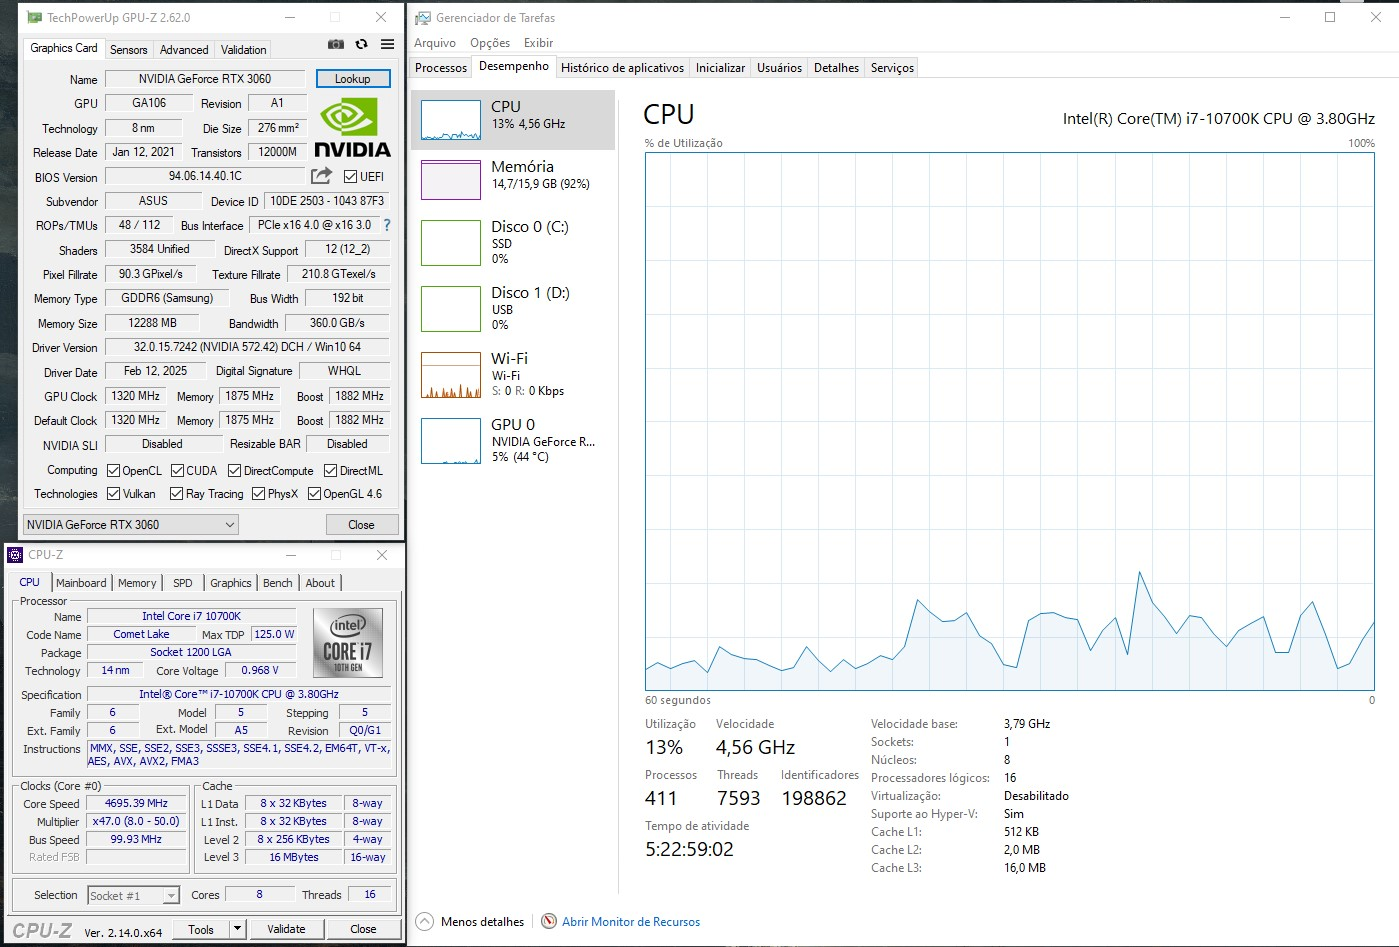

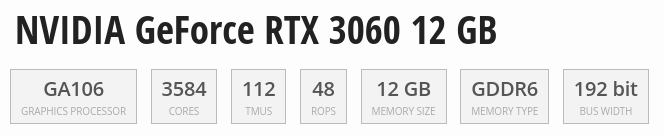

##**Solução Sequencial do problema**

In [ ]:
%%writefile MSS_sequencial.c

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <limits.h>

#define N 10000
#define K 5

int MaxIncreasingSub(int arr[], int n, int k) {
    int **dp, ans = -1;
    dp = (int **)malloc(n * sizeof(int *));
    for (int i = 0; i < n; i++) {
        dp[i] = (int *)malloc((k + 1) * sizeof(int));
        for (int j = 0; j <= k; j++) {
            dp[i][j] = -1;
        }
    }

    for (int i = 0; i < n; i++) {
        dp[i][1] = arr[i];
    }

    for (int i = 1; i < n; i++) {
        for (int j = 0; j < i; j++) {
            if (arr[j] < arr[i]) {
                for (int l = 1; l <= k - 1; l++) {
                    if (dp[j][l] != -1) {
                        dp[i][l + 1] = (dp[i][l + 1] > dp[j][l] + arr[i]) ? dp[i][l + 1] : (dp[j][l] + arr[i]);
                    }
                }
            }
        }
    }

    for (int i = 0; i < n; i++) {
        if (ans < dp[i][k]) {
            ans = dp[i][k];
        }
    }

    // Liberação da memória alocada
    for (int i = 0; i < n; i++) {
        free(dp[i]);
    }
    free(dp);

    return (ans == -1) ? 0 : ans;
}


int main()
{
    int arr[N];

    // Abre o arquivo para leitura
    FILE *file = fopen("input.in", "r");
    if (file == NULL)
    {
        printf("Erro ao abrir o arquivo input.in\n");
        return 1;
    }

    // Lê os valores do arquivo
    for (int i = 0; i < N; i++)
    {
        if (fscanf(file, "%d", &arr[i]) != 1)
        {
            printf("Erro ao ler os dados do arquivo\n");
            fclose(file);
            return 1;
        }
    }
    fclose(file);

    clock_t start_time = clock();
    int result = MaxIncreasingSub(arr, N, K);
    clock_t end_time = clock();
    double time_taken = ((double)(end_time - start_time)) / CLOCKS_PER_SEC;

    printf("N = %d; K = %d; TEMPO_EXECUCAO: %f; RESULTADO: %d\n", N, K, time_taken * 1000, result);

    return 0;
}

In [ ]:
! g++ MSS_sequencial.c -o MSS_sequencial

In [ ]:
!./MSS_sequencial

## **Estratégias de paralelização**

###**1) Inicialização do vetor arr no main**



In [ ]:
for (int i = 0; i < N; i++) {
    arr[i] = rand() % 1000;
}

**Paralelização:** Sim, vale a pena

**Justificativa:** A inicialização do vetor arr pode ser feita em paralelo, pois cada elemento é independente dos outros

###**2) Inicialização da matriz dp na função MaxIncreasingSub**



In [ ]:
for (int i = 0; i < n; i++) {
    dp[i] = (int *)malloc((k + 1) * sizeof(int));
    for (int j = 0; j <= k; j++) {
        dp[i][j] = -1;
    }
}

**Paralelização:** Sim, vale a pena

**Justificativa:** A inicialização da matriz dp pode ser paralelizada, pois cada linha da matriz pode ser inicializada independentemente


###**3)   Preenchimento inicial da matriz dp**



In [ ]:
for (int i = 0; i < n; i++) {
    dp[i][1] = arr[i];
}

**Paralelização:** Sim, vale a pena

**Justificativa:** Cada iteração é independente, então pode ser paralelizada

###**4)   Loop principal que preenche a matriz dp**



In [ ]:
for (int i = 1; i < n; i++) {
    for (int j = 0; j < i; j++) {
        if (arr[j] < arr[i]) {
            for (int l = 1; l <= k - 1; l++) {
                if (dp[j][l] != -1) {
                    dp[i][l + 1] = (dp[i][l + 1] > dp[j][l] + arr[i]) ? dp[i][l + 1] : (dp[j][l] + arr[i]);
                }
            }
        }
    }
}

**Paralelização:** Complexa, mas possível se feito com cuidado

**Justificativa:** O loop externo (i) até pode ser paralelizado, já que para cada i o cálculo de dp[i] é independente das demais iterações sobre i, porém é uma estratégia limitada, já que é um número curto de iterações e o overhead pode acabar sendo superior do que o ganho de desempenho. O loop interno (j) pode ser paralelizado, mas isso requer cuidado para evitar condições de corrida ao atualizar dp[i][l + 1]. Uma abordagem seria usar reduções ou seções críticas, mas isso pode introduzir overhead, o que torna a estratégia dependente do número de recursos computacionais disponíveis.

###**5)   Encontrar o valor máximo na matriz dp**



In [ ]:
for (int i = 0; i < n; i++) {
    if (ans < dp[i][k]) {
        ans = dp[i][k];
    }
}

**Paralelização:** Sim, vale a pena.

**Justificativa:** Pode ser paralelizado usando uma redução para encontrar o máximo:

## **Definidas as estratégias, vamos para a parte prática!**

###**Implementação paralela para memória compartilhada**


###**Código paralelizado usando openMP**

In [ ]:
%%writefile MSS_openmp.c

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <omp.h>

// Define valores padrão, mas permite sobrescrita via compilação
#define N 7500
#define K 50

int MaxIncreasingSub(int arr[], int n, int k) {
    int **dp, ans = -1;
    dp = (int **)malloc(n * sizeof(int *));
    for (int i = 0; i < n; i++) {
        dp[i] = (int *)malloc((k + 1) * sizeof(int));
        for (int j = 0; j <= k; j++) {
            dp[i][j] = -1;
        }
    }

    for (int i = 0; i < n; i++) {
        dp[i][1] = arr[i];
    }

    for (int i = 1; i < n; i++) {
        #pragma omp parallel for
        for (int j = 0; j < i; j++) {
            if (arr[j] < arr[i]) {
                for (int l = 1; l <= k - 1; l++) {
                    if (dp[j][l] != -1) {
                            #pragma omp critical
                            if (dp[i][l + 1] < dp[j][l] + arr[i]) {
                                dp[i][l + 1] = dp[j][l] + arr[i];
                            }
                    }
                }
            }
        }
    }

    #pragma omp parallel for reduction(max: ans)
    for (int i = 0; i < n; i++) {
        if (dp[i][k] > ans) {
            ans = dp[i][k];
        }
    }

    for (int i = 0; i < n; i++) {
        free(dp[i]);
    }0m1.893s
user	0m1.596s
sys	0m0.228s
    free(dp);

    return (ans == -1) ? 0 : ans;
}

int main() {
    int arr[N];

    // Abre o arquivo para leitura
    FILE *file = fopen("input.in", "r");
    if (file == NULL) {
        printf("Erro ao abrir o arquivo input.in\n");
        return 1;
    }

    // Lê os valores do arquivo
    for (int i = 0; i < N; i++) {
        if (fscanf(file, "%d", &arr[i]) != 1) {
            printf("Erro ao ler os dados do arquivo\n");
            fclose(file);
            return 1;
        }
    }0m1.893s
user	0m1.596s
sys	0m0.228s
    fclose(file);

0m1.893s
user	0m1.596s
sys	0m0.228s
    double start_time = omp_get_wtime();
    int result = MaxIncreasingSub(arr, N, K);
    double end_time = omp_get_wtime();
    double time_taken = end_time - start_time;

    printf("N = %d; K = %d; TEMPO_EXECUCAO: %f; RESULTADO: %d\n", N, K, time_taken*1000, result);

    return 0;
}

### **Para compilar:**

In [ ]:
!gcc -fopenmp MSS_openmp.c -o testemp

In [ ]:
!./MSS_openmp

###**Implementação paralela para memória distribuída**

###**Código paralelizado usando CUDA**

In [ ]:
%%writefile MSS_cuda.cu
0m1.893s
user	0m1.596s
sys	0m0.228s
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>

#define N 7500
#define K 100

__global__ void computeDP(int *arr, int *dp, int n, int k, int i) {
    int j = blockIdx.x * blockDim.x + threadIdx.x;
    if (j >= i) return;

    if (arr[j] < arr[i]) {
        for (int l = 1; l <= k - 1; l++) {
            if (dp[j * (k + 1) + l] != -1) {
                int new_val = dp[j * (k + 1) + l] + arr[i];
                atomicMax(&dp[i * (k + 1) + (l + 1)], new_val);
            }
        }
    }
}

int MaxIncreasingSub(int *arr, int n, int k) {
    int *d_arr, *d_dp;
    size_t sizeArr = n * sizeof(int);
    size_t sizeDP = n * (k + 1) * sizeof(int);

    cudaMalloc((void **)&d_arr, sizeArr);
    cudaMalloc((void **)&d_dp, sizeDP);

    int *h_dp = (int *)malloc(sizeDP);
    for (int i = 0; i < n * (k + 1); i++) {
        h_dp[i] = -1;
    }
    for (int i = 0; i < n; i++) {
        h_dp[i * (k + 1) + 1] = arr[i];
    }

    cudaMemcpy(d_dp, h_dp, sizeDP, cudaMemcpyHostToDevice);
    cudaMemcpy(d_arr, arr, sizeArr, cudaMemcpyHostToDevice);


    for (int i = 1; i < n; i++) {
        int threadsPerBlock = 256;
        int blocksPerGrid = (i + threadsPerBlock - 1) / threadsPerBlock;
        computeDP<<<blocksPerGrid, threadsPerBlock>>>(d_arr, d_dp, n, k, i);
        cudaDeviceSynchronize();
    }

    cudaMemcpy(h_dp, d_dp, sizeDP, cudaMemcpyDeviceToHost);

    int ans = -1;
    for (int i = 0; i < n; i++) {
        if (h_dp[i * (k + 1) + k] > ans) {
            ans = h_dp[i * (k + 1) + k];
        }
    }

    cudaFree(d_arr);
    cudaFree(d_dp);
    free(h_dp);

    return (ans == -1) ? 0 : ans;
}

int main() {
    int arr[N];
    // Abre o arquivo para leitura
    FILE *file = fopen("input.in", "r");
    if (file == NULL) {
        printf("Erro ao abrir o arquivo input.in\n");
        return 1;
    }

    // Lê os valores do arquivoTrabalhos
    for (int i = 0; i < N; i++) {
        if (fscanf(file, "%d", &arr[i]) != 1) {
            printf("Erro ao ler os dados do arquivo\n");
            fclose(file);
            return 1;
        }
    }
    fclose(file);


    cudaEvent_t start, stop;
    float time;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start, 0);

    int result = MaxIncreasingSub(arr, N, K);

    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&time, start, stop);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    printf("N = %d; K = %d; TEMPO_EXECUCAO: %f ms; RESULTADO: %d\n", N, K, time, result);

    return 0;
}

###**Para compilar:**

In [ ]:
!nvcc  MSS_cuda.cu -o  MSS_cuda

In [ ]:
!./ MSS_cuda

#**Comparando os tempos de execução e speed up das implementações**


## Resultados Sequenciais
### Em função de K (N = 5000)
```
K = 5; TEMPO_EXECUCAO: 130.21 ms
K = 10; TEMPO_EXECUCAO: 239.58 ms
K = 20; TEMPO_EXECUCAO: 473.96 ms
K = 50; TEMPO_EXECUCAO: 947.92 ms
K = 75; TEMPO_EXECUCAO: 1255.21 ms
K = 100; TEMPO_EXECUCAO: 1510.42 ms
```
### Em função de N (K = 5)
```
N = 500; TEMPO_EXECUCAO: 0.00 ms
N = 1000; TEMPO_EXECUCAO: 5.21 ms
N = 2000; TEMPO_EXECUCAO: 20.83 ms
N = 5000; TEMPO_EXECUCAO: 125.00 ms
N = 7500; TEMPO_EXECUCAO: 296.88 ms
N = 10000; TEMPO_EXECUCAO: 515.63 ms
```
## Resultados com Open MP

### Em função de K (N = 5000)
```
K = 5; TEMPO_EXECUCAO: 6244.1 ms
K = 10; TEMPO_EXECUCAO: 12455.5 ms
K = 20; TEMPO_EXECUCAO: 20022.21 ms
K = 50; TEMPO_EXECUCAO: 27730.00 ms
K = 75; TEMPO_EXECUCAO: 32603.48 ms
K = 100; TEMPO_EXECUCAO: 36383.68 ms
```
### Em função de N (K = 5)
```
N = 500; TEMPO_EXECUCAO: 70.73 ms
N = 1000; TEMPO_EXECUCAO: 170.44 ms
N = 2000; TEMPO_EXECUCAO: 970.09 ms
N = 5000; TEMPO_EXECUCAO: 5129.65 ms
N = 7500; TEMPO_EXECUCAO: 13464.97 ms
N = 10000; TEMPO_EXECUCAO: 20363.50 ms
```

# Resultados com CUDA

### Em função de K (N = 5000)
```
K = 5; TEMPO_EXECUCAO: 117.62 ms
K = 10; TEMPO_EXECUCAO: 117.88 ms
K = 20; TEMPO_EXECUCAO: 121.50 ms
K = 50; TEMPO_EXECUCAO: 156.33 ms
K = 75; TEMPO_EXECUCAO: 151.79 ms
K = 100; TEMPO_EXECUCAO: 205.15 ms
```
### Em função de N (K = 5)
```
N = 500; TEMPO_EXECUCAO: 12.84 ms
N = 1000; TEMPO_EXECUCAO: 24.92 ms
N = 2000; TEMPO_EXECUCAO: 48.85 ms
N = 5000; TEMPO_EXECUCAO: 121.38 ms
N = 7500; TEMPO_EXECUCAO: 180.28 ms
N = 10000; TEMPO_EXECUCAO: 238.30 ms
```

In [ ]:
%matplotlib inline

In [ ]:
%%writefile desempenho.py
import re
import matplotlib.pyplot as plt
import numpy as np

# Dados diretamente no código
dados = {
    'sequencial_N': """
    N = 500; K = 5; TEMPO_EXECUCAO: 0.00; RESULTADO: 49266
    N = 1000; K = 5; TEMPO_EXECUCAO: 5.21; RESULTADO: 49749
    N = 2000; K = 5; TEMPO_EXECUCAO: 20.83; RESULTADO: 49778
    N = 5000; K = 5; TEMPO_EXECUCAO: 125.00; RESULTADO: 49895
    N = 7500; K = 5; TEMPO_EXECUCAO: 296.88; RESULTADO: 49967
    N = 10000; K = 5; TEMPO_EXECUCAO: 515.63; RESULTADO: 49981
    """,
    'cuda_N': """
    N = 500; K = 5; TEMPO_EXECUCAO: 12.84; RESULTADO: 49266
    N = 1000; K = 5; TEMPO_EXECUCAO: 24.92; RESULTADO: 49749
    N = 2000; K = 5; TEMPO_EXECUCAO: 48.85; RESULTADO: 49778
    N = 5000; K = 5; TEMPO_EXECUCAO: 121.38; RESULTADO: 49895
    N = 7500; K = 5; TEMPO_EXECUCAO: 180.28; RESULTADO: 49967
    N = 10000; K = 5; TEMPO_EXECUCAO: 238.30; RESULTADO: 49981
    """,
    'omp_N': """
    N = 500; K = 5; TEMPO_EXECUCAO: 70.73; RESULTADO: 49266
    N = 1000; K = 5; TEMPO_EXECUCAO: 170.44; RESULTADO: 49749
    N = 2000; K = 5; TEMPO_EXECUCAO: 970.09; RESULTADO: 49778
    N = 5000; K = 5; TEMPO_EXECUCAO: 5129.65; RESULTADO: 49895
    N = 7500; K = 5; TEMPO_EXECUCAO: 13464.97; RESULTADO: 49967
    N = 10000; K = 5; TEMPO_EXECUCAO: 20363.50; RESULTADO: 49981
    """,
    'sequencial_K': """
    N = 5000; K = 5; TEMPO_EXECUCAO: 130.21; RESULTADO: 49895
    N = 5000; K = 10; TEMPO_EXECUCAO: 239.58; RESULTADO: 99559
    N = 5000; K = 20; TEMPO_EXECUCAO: 473.96; RESULTADO: 197594
    N = 5000; K = 50; TEMPO_EXECUCAO: 947.92; RESULTADO: 464239
    N = 5000; K = 75; TEMPO_EXECUCAO: 1255.21; RESULTADO: 637749
    N = 5000; K = 100; TEMPO_EXECUCAO: 1510.42; RESULTADO: 725723
    """,
    'cuda_K': """
    N = 5000; K = 5; TEMPO_EXECUCAO: 117.62; RESULTADO: 49895
    N = 5000; K = 10; TEMPO_EXECUCAO: 117.88; RESULTADO: 99559
    N = 5000; K = 20; TEMPO_EXECUCAO: 121.50; RESULTADO: 197594
    N = 5000; K = 50; TEMPO_EXECUCAO: 156.33; RESULTADO: 464239
    N = 5000; K = 75; TEMPO_EXECUCAO: 151.79; RESULTADO: 637749
    N = 5000; K = 100; TEMPO_EXECUCAO: 205.15; RESULTADO: 725723
    """,
    'omp_K': """
    N = 5000; K = 5; TEMPO_EXECUCAO: 6244.10; RESULTADO: 49895
    N = 5000; K = 10; TEMPO_EXECUCAO: 12455.56; RESULTADO: 99559
    N = 5000; K = 20; TEMPO_EXECUCAO: 20022.21; RESULTADO: 197594
    N = 5000; K = 50; TEMPO_EXECUCAO: 27730.00; RESULTADO: 464239
    N = 5000; K = 75; TEMPO_EXECUCAO: 32603.48; RESULTADO: 637749
    N = 5000; K = 100; TEMPO_EXECUCAO: 36383.68; RESULTADO: 725723
    """
}


def parse_data(data_string):
    data = {'N': {}, 'K': {}}
    for line in data_string.strip().split('\n'):
        match = re.findall(r'N = (\d+); K = (\d+); TEMPO_EXECUCAO: ([\d.]+)', line)
        if match:
            n = int(match[0][0])
            k = int(match[0][1])
            time = float(match[0][2])

            if k not in data['K']:
                data['K'][k] = []
            data['K'][k].append(time)

            if n not in data['N']:
                data['N'][n] = []
            data['N'][n].append(time)

    for var in ['N', 'K']:
        for key in data[var]:
            data[var][key] = np.mean(data[var][key])

    return data


def plot_performance():
    approaches = ['cuda', 'omp', 'sequencial']
    colors = {'cuda': 'red', 'omp': 'blue', 'sequencial': 'green'}

    fig, axs = plt.subplots(2, 1, figsize=(12, 12))

    for approach in approaches:
        data = parse_data(dados[f'{approach}_N'])
        n_values = sorted(data['N'].keys())
        times = [data['N'][n] for n in n_values]
        axs[0].plot(n_values, times, 'o-', color=colors[approach], label=approach.upper())

    axs[0].set_title('Desempenho em Função de N (K fixo)')
    axs[0].set_xlabel('N')
    axs[0].set_ylabel('Tempo de Execução (ms)')
    axs[0].set_xscale('log')
    axs[0].grid(True, which='both', linestyle='--')
    axs[0].legend()

    for approach in approaches:
        data = parse_data(dados[f'{approach}_K'])
        k_values = sorted(data['K'].keys())
        times = [data['K'][k] for k in k_values]
        axs[1].plot(k_values, times, 'o-', color=colors[approach], label=approach.upper())

    axs[1].set_title('Desempenho em Função de K (N fixo)')
    axs[1].set_xlabel('K')
    axs[1].set_ylabel('Tempo de Execução (ms)')
    axs[1].grid(True, which='both', linestyle='--')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


def plot_speedup():
    seq_data = parse_data(dados['sequencial_K'])['K']
    cuda_data = parse_data(dados['cuda_K'])['K']
    omp_data = parse_data(dados['omp_K'])['K']

    k_values = sorted(seq_data.keys())
    speedup_cuda = [seq_data[k] / cuda_data[k] for k in k_values]
    speedup_omp = [seq_data[k] / omp_data[k] for k in k_values]

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, speedup_cuda, 'o-', color='red', label='CUDA/Sequencial')
    plt.plot(k_values, speedup_omp, 'o-', color='blue', label='OpenMP/Sequencial')

    plt.title('Speedup em Função de K')
    plt.xlabel('K')
    plt.ylabel('Speedup (X mais rápido)')
    plt.grid(True, which='both', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_performance()
    plot_speedup()
    print("Gráficos gerados com sucesso!")


Overwriting desempenho.py


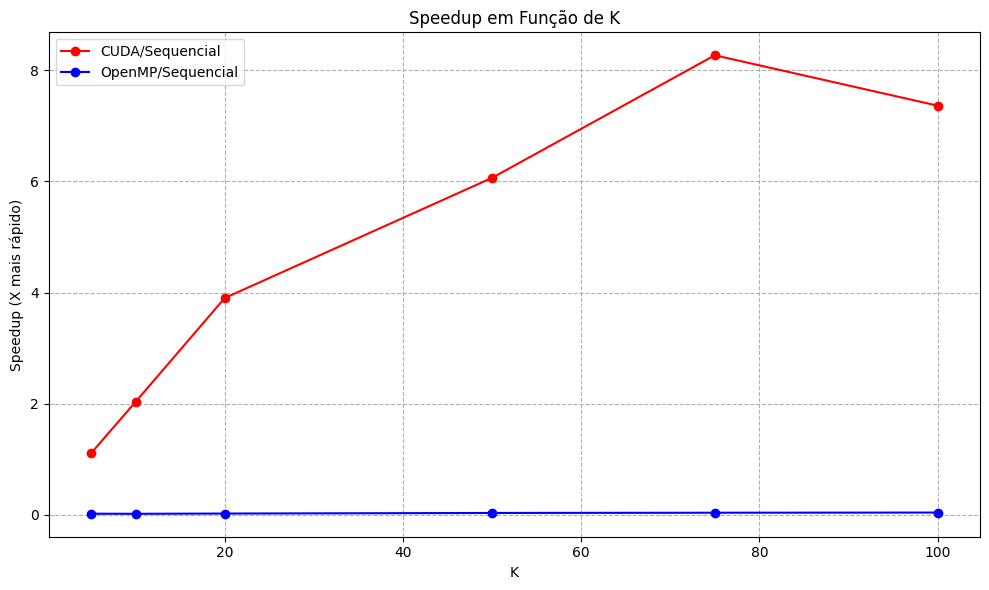

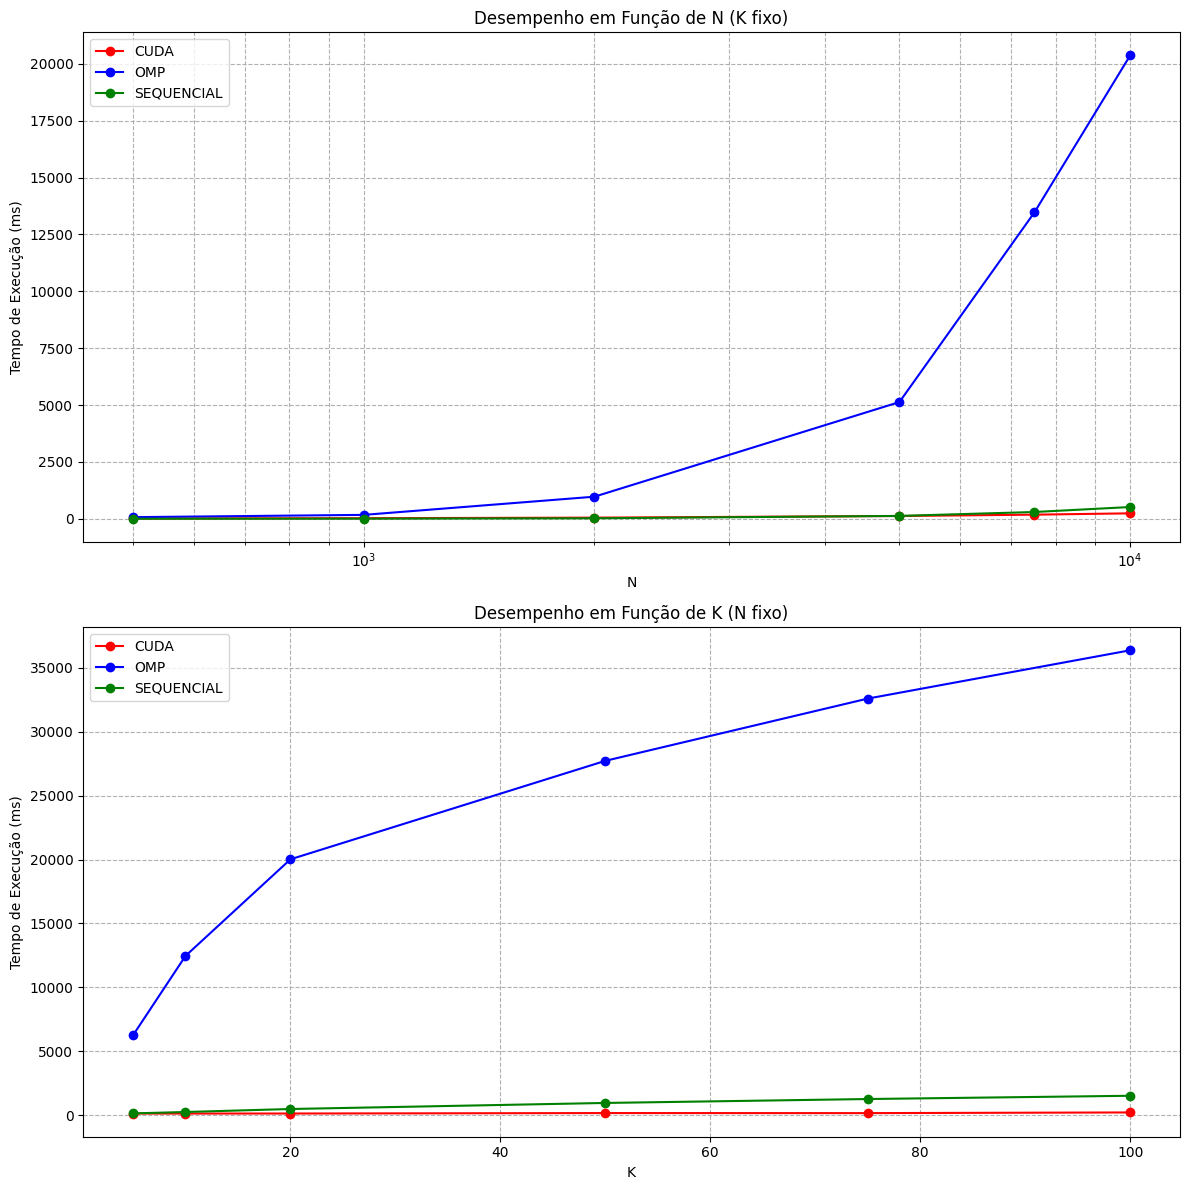

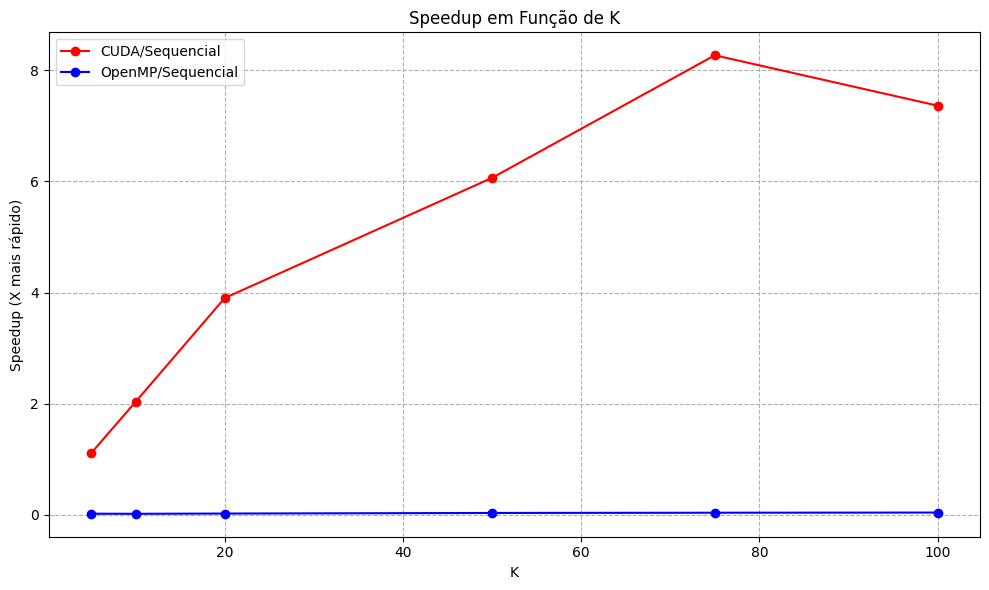

Gráficos gerados com sucesso!


<Figure size 640x480 with 0 Axes>

In [ ]:
%run desempenho.py

## **Trabalho Relacionado: Soluções para os problemas da soma máxima e do k-ésimo menor elemento de uma sequência usando o modelo BSP/CGM - Anderson Corrêa de Lima, UFMS**



### **Descrição**

O autor apresenta 5 problemas variados envolvendo somas máximas de diferentes formas. Para a apresentação, o mais relevante é o **problema da subsequência de soma máxima**. Este problema possui divergências em relação ao problema que solucionamos, já que o nosso possuia uma subsequência não contígua de tamanho k e com valores não negativos, mas ainda sim sua abordagem é relavante ser discutida.



### **O modelo BSP/CGM**

O modelo de paralelização BPS/GCM (Bulk Synchronous Parallel / Global Communication Model) combina dois paradigmas para melhorar a eficiência de processamento paralelo. O Bulk Synchronous Parallel (BPS) organiza o cálculo em etapas, onde cada processo executa uma parte da tarefa localmente e, em seguida, sincroniza com outros processos em pontos específicos. Já o Global Communication Model (GCM) lida com a comunicação entre os processos, garantindo que as trocas de informações sejam feitas de forma eficiente durante as fases de sincronização.


### **A subsequência de soma máxima**

Dada uma sequência de números reais, o problema de identificar a subsequência contígua
com a maior soma de seus elementos é chamado de problema da subsequência de soma
máxima.

Exemplo: Considere a seguinte sequência
(3, 5, 10, −5, −30, 5, 7, 2, −3, 10, −7, 5). Neste caso uma subsequência de soma máxima é
M = (5, 7, 2, −3, 10) com soma total TM = 21.



### **Algoritmos**

#### **Sequencial**

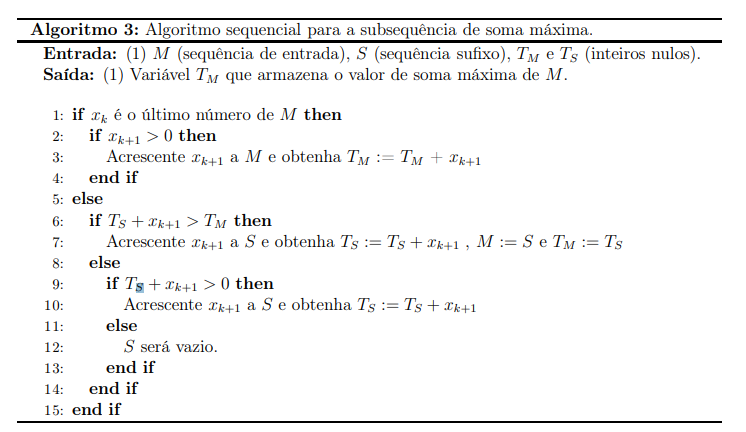

#### **Execução do Algoritmo Sequencial com a sequência (3, 5, 10, −5, −30, 5, 7, 2, −3, 10, −7, 5)**
1. Começa com \( T_M = 3 \), \( T_S = 3 \).
2. Adiciona 5 → \( T_S = 8 \), \( T_M = 8 \).
3. Adiciona 10 → \( T_S = 18 \), \( T_M = 18 \).
4. Adiciona −5 → \( T_S = 13 \), \( T_M = 18 \).
5. Adiciona −30 → \( T_S = -17 \), \( T_M = 18 \). Como \( T_S \) ficou negativo, reinicia \( T_S \).
6. Adiciona 5 → \( T_S = 5 \), \( T_M = 18 \).
7. Adiciona 7 → \( T_S = 12 \), \( T_M = 18 \).
8. Adiciona 2 → \( T_S = 14 \), \( T_M = 18 \).
9. Adiciona −3 → \( T_S = 11 \), \( T_M = 18 \).
10. Adiciona 10 → \( T_S = 21 \), \( T_M = 21 \).
11. Adiciona −7 → \( T_S = 14 \), \( T_M = 21 \).
12. Adiciona 5 → \( T_S = 19 \), \( T_M = 21 \).

**Resultado final**: **21**.

#### **Paralelo**

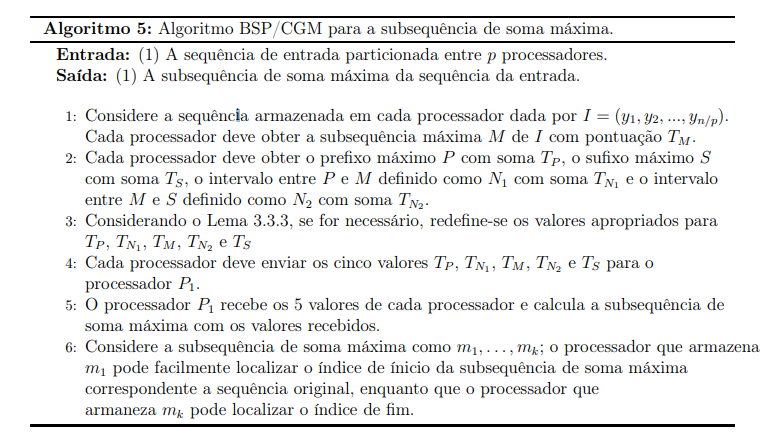

#### **Execução do Algoritmo Paralelo com a sequência (3, 5, 10, −5, −30, 5, 7, 2, −3, 10, −7, 5)**

#### **Passo 1: Processamento Local**  

1. **Processador 1:** (3, 5, 10, −5)  
   - \( T_P = 3 + 5 + 10 - 5 = 13 \)  
   - \( T_N = max(3, 3+5, 3+5+10, 3+5+10-5) = 18 \)  
   - \( T_M = max(3, 3+5, 3+5+10, 3+5+10-5) = 18 \)  
   - \( T_S = max(-5, 10-5, 5+10-5, 3+5+10-5) = 13 \)  

2. **Processador 2:** (-30, 5, 7, 2)  
   - \( T_P = -30 + 5 + 7 + 2 = -16 \)  
   - \( T_N = max(-30, -30+5, -30+5+7, -30+5+7+2) = -16 \)  
   - \( T_M = max(-30, 5, 5+7, 5+7+2) = 14 \)  
   - \( T_S = max(2, 7+2, 5+7+2, -30+5+7+2) = 14\)  

3. **Processador 3:** (-3, 10, -7, 5)  
   - \( T_P = -3 + 10 - 7 + 5 = 5 \)  
   - \( T_N = max(-3, -3+10, -3+10-7, -3+10-7+5) = 7 \)  
   - \( T_M = max(-3, 10, 10-7, 10-7+5) = 10 \)  
   - \( T_S = max(5, -7+5, 10-7+5, -3+10-7+5) = 5 \)  


#### **Passo 2: Combinação dos Resultados**  

Agora combinamos os resultados dos processadores:  

1. A **maior soma máxima local** foi 18 no Processador 1.  
2. A combinação da melhor subsequência entre dois blocos:  
   - \( T_S \) do Processador 1 \( 13 \) somado com \( T_N \) do Processador 2 \( -16 \) não melhora a soma.  
   - \( T_S \) do Processador 2 \( 12 \) somado com \( T_N \) do Processador 3 \( 7 \) resulta em **21**.  

**Resultado final:** **21**.


### **Desempenho: Sequencial x CUDA**

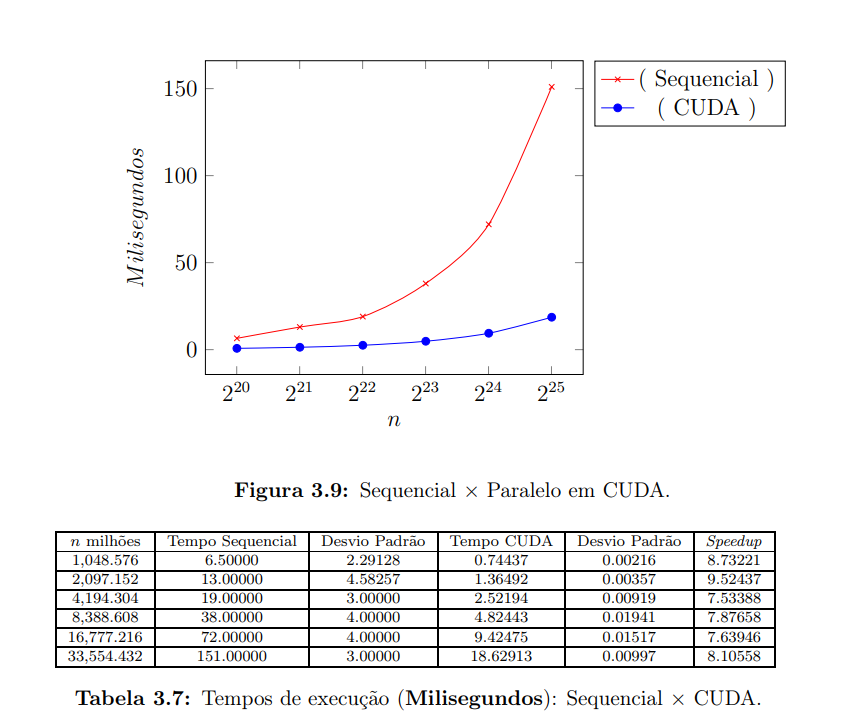

##**Conclusão**

Após todos esses estudos, vimos a importância da programação paralela e distribuída na otimização e melhoria no desempenho de sistemas, mostrando que mesmo que algo funcione, pode funcionar melhor e de forma mais eficiente. Tanto na aplicação com memória compartilhada quanto na memória distribuída, constatamos que a divisão do problema em subproblemas menores e a execução simultânea de múltiplas tarefas resultam em uma redução significativa no tempo de processamento. A paralelização proporciona vantagens distintas, dependendo da arquitetura e dos recursos disponíveis. A escolha da abordagem correta, seja em ambientes com memória compartilhada ou distribuída, pode fazer toda a diferença na escalabilidade e no desempenho geral da solução, tornando a paralelização uma ferramenta essencial para problemas de grande escala e complexidade.

##**Referências Bibliográficas**

*  14th Marathon of Parallel Programming SBAC-PAD & WSCAD – 2019. Disponível em: http://lspd.mackenzie.br/marathon/19/problemset.pdf. Acesso em: 14 fev. 2025.


*   UNIVERSIDADE FEDERAL DE MATO GROSSO DO SUL. Soluções para os problemas da soma máxima e do k-ésimo menor elemento de uma sequência usando o modelo BSP/CGM. Disponível em: https://posgraduacao.ufms.br/portal/trabalho-arquivos/download/2297. Acesso em: 14 fev. 2025.



*   PERUMALLA, Kalyan; DEO, Narsingh. Parallel algorithms for maximum subsequence and maximum subarray. Parallel Processing Letters, 1995. Disponível em: https://kalper.net/kp/publication/pub-016-mss-ppl95/pub-016-mss-ppl95.pdf. Acesso em: 19 fev. 2025.

*  ALVES, C. E. R.; CÁCERES, E. N.; SONG, S. W. Computing Maximum Subsequence in Parallel. 2003. Disponível em: https://www.ime.usp.br/~song/mac5705/wob03.pdf. Acesso em: 19 fev. 2025.

